Full bytes with CRC:
0x8d 0x40 0x6b 0x90 0x20 0x15 0xa6 0x78 0xd4 0xd2 0x20 0xaa 0x4b 0xda 

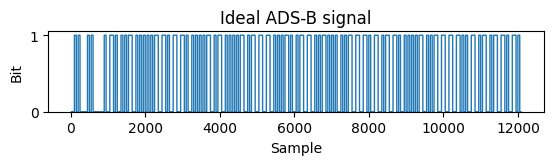

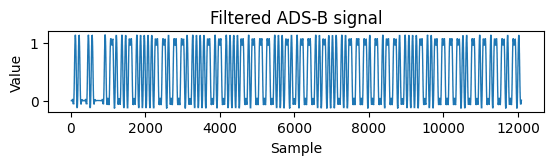

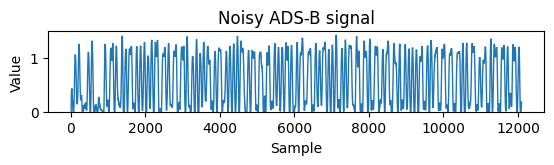

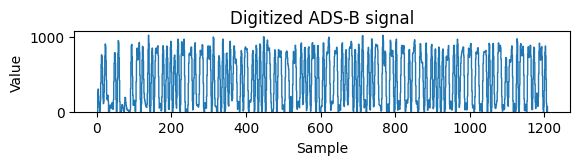

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from M_Functions.signal_generator import signal_start_pause_length, generate_ADSB, digitize_signal, get_signal_energy, normalize_signal, get_last_generated_signal_length
from M_Functions.crc import generate_adsb_crc
from preambules_list import preambule_list, Preambule

#Configuration
amplitude = 1
data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])

#Generate and append CRC
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits
print("Full bytes with CRC:")
for i in full_bits:
    print(hex(i) + " ", end='')

#Generate and plot simulated ADS-B
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, full_bits)

plt.subplot(4, 1, 1)
plt.stairs(ideal_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Bit')
plt.title('Ideal ADS-B signal')
plt.show()

plt.subplot(4, 1, 2)
plt.stairs(filtered_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Filtered ADS-B signal')
plt.show()

plt.subplot(4, 1, 3)
plt.stairs(noisy_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Noisy ADS-B signal')
plt.show()

#Digitize signal
digitized_signal, digitized_t = digitize_signal(noisy_signal, 100E6, 10E6, 1.4, 2**10)

plt.subplot(4, 1, 4)
plt.stairs(digitized_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Digitized ADS-B signal')
plt.show()

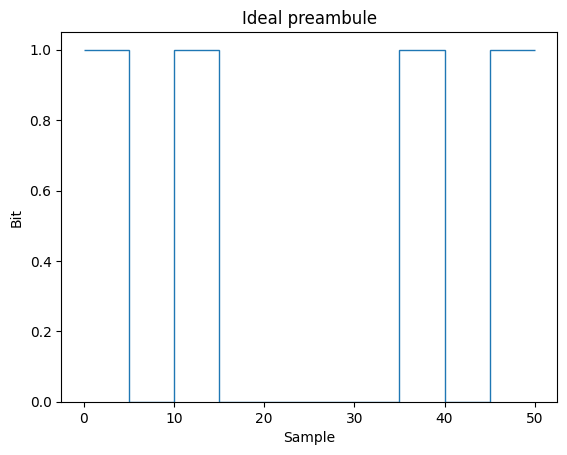

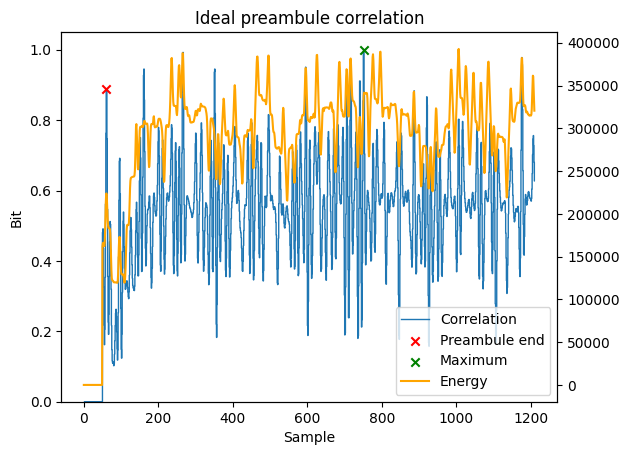

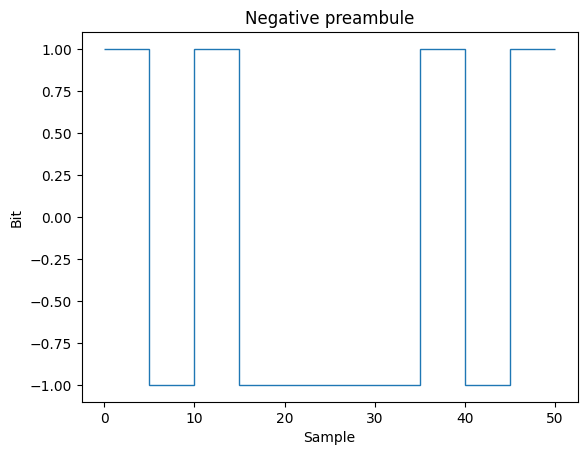

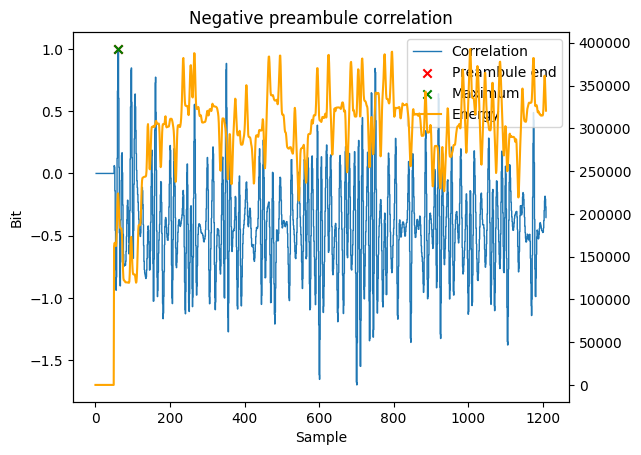

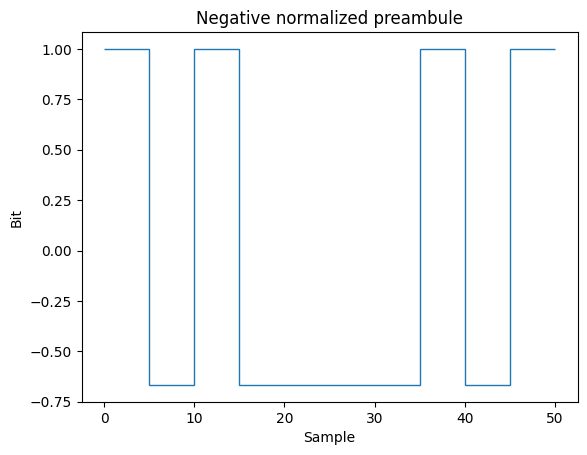

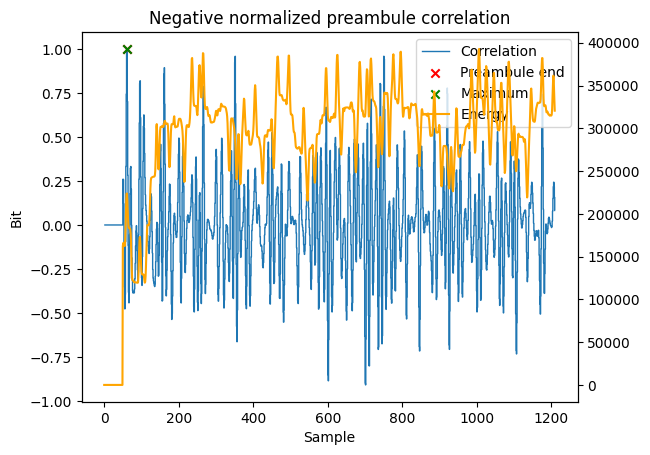

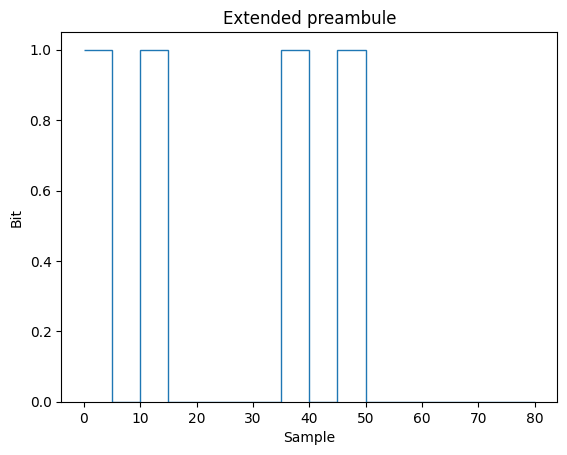

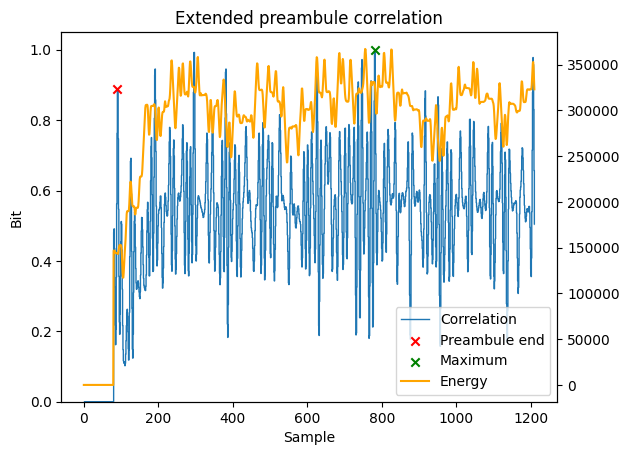

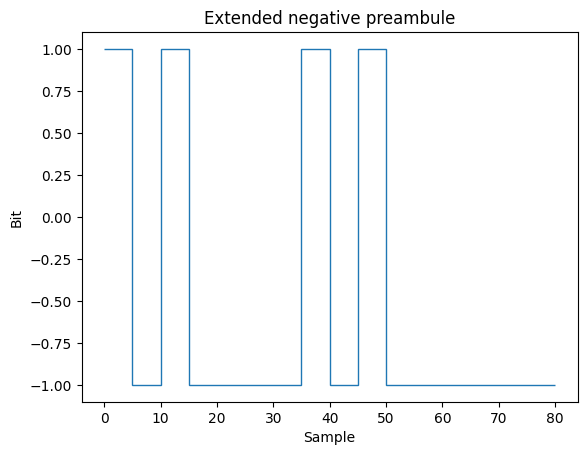

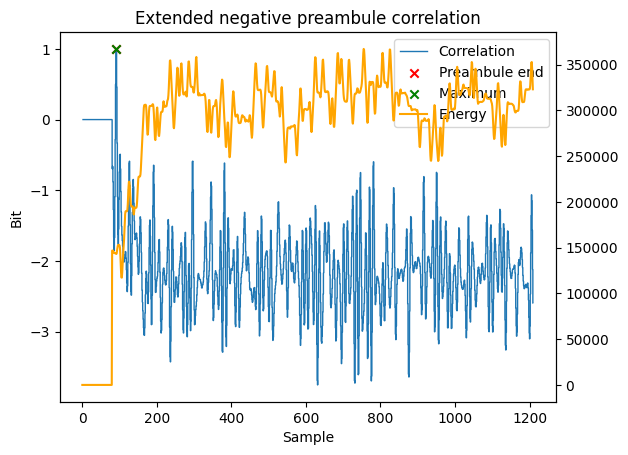

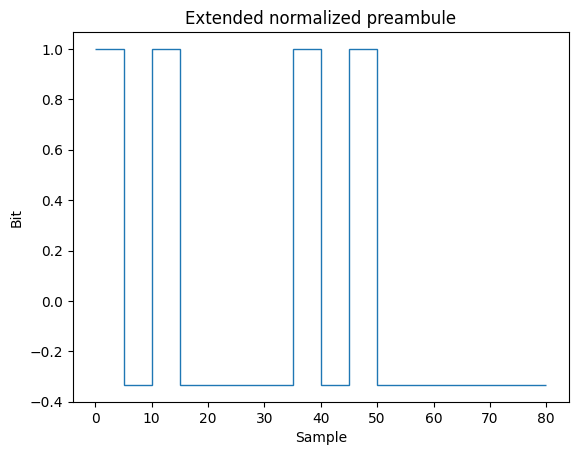

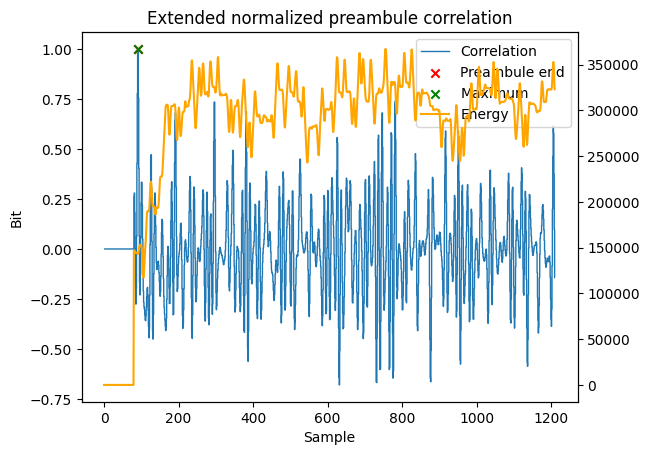

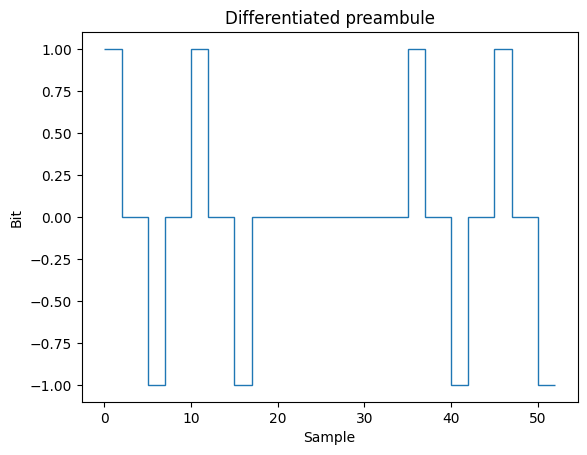

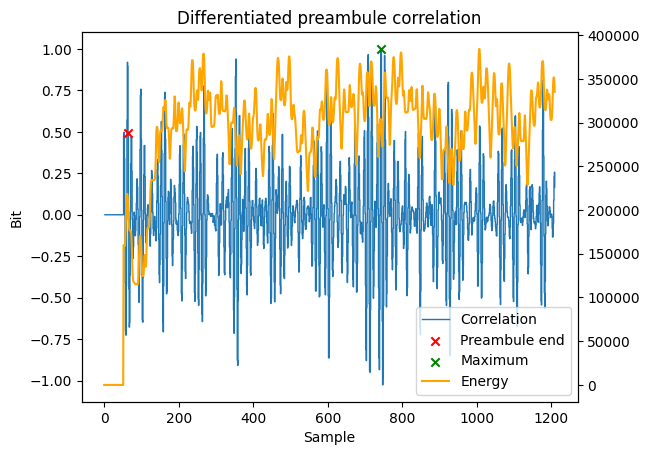

In [26]:
for preambule in preambule_list:
    curr_preambule_corr = preambule.get_correlation(digitized_signal)
    curr_energy = get_signal_energy(digitized_signal, len(preambule.get_coefficients()))
    normalize_signal(curr_preambule_corr)
    max_idx = np.argmax(curr_preambule_corr)
    # Preambule plot
    plt.stairs(preambule.get_coefficients(), baseline=None)
    plt.xlabel('Sample')
    plt.ylabel('Bit')
    plt.title(preambule.get_name() + " preambule")
    plt.show()
    # Correlation and energy plot
    fig, ax1 = plt.subplots()
    plot1 = ax1.stairs(curr_preambule_corr, label="Correlation", baseline=None)
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Bit')
    plot2 = ax1.scatter(signal_start_pause_length + preambule.get_expected_maximum(),
                curr_preambule_corr[signal_start_pause_length + preambule.get_expected_maximum()],
                marker='x', color='red', label="Preambule end")
    plot3 = ax1.scatter(max_idx, curr_preambule_corr[max_idx], marker='x', color='green', label="Maximum")
    ax2 = ax1.twinx()
    plot4, = ax2.plot(curr_energy, color='orange', label="Energy")
    plt.title(preambule.get_name() + " preambule correlation")

    plots = [plot1, plot2, plot3, plot4]
    plots_labels = [plot.get_label() for plot in plots]
    ax1.legend(plots, plots_labels)
    plt.show()


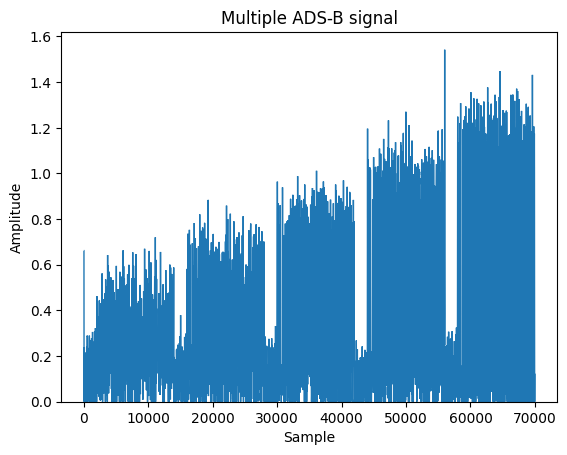

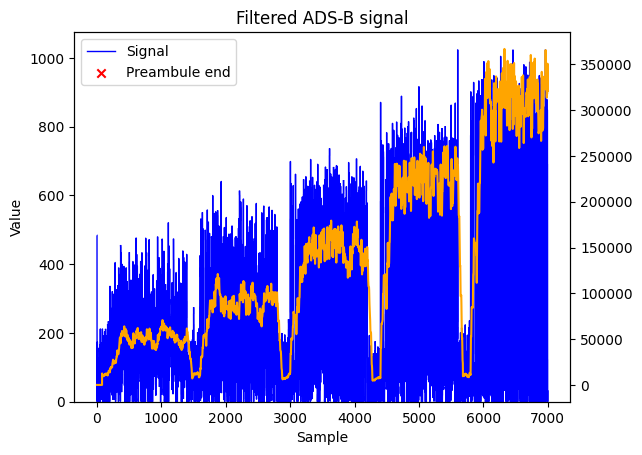

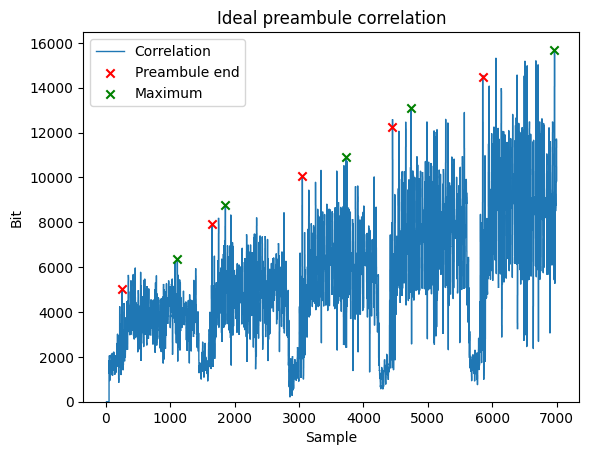

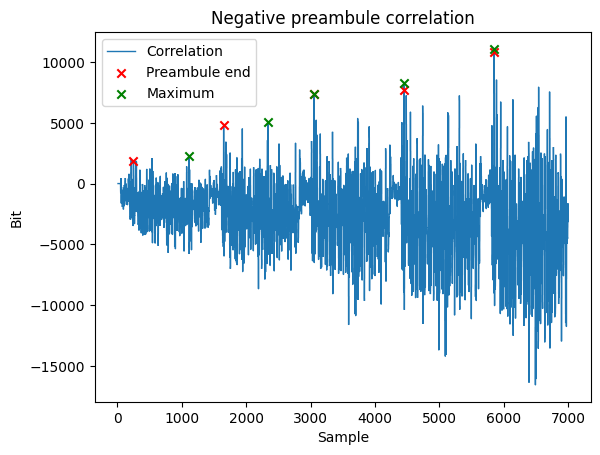

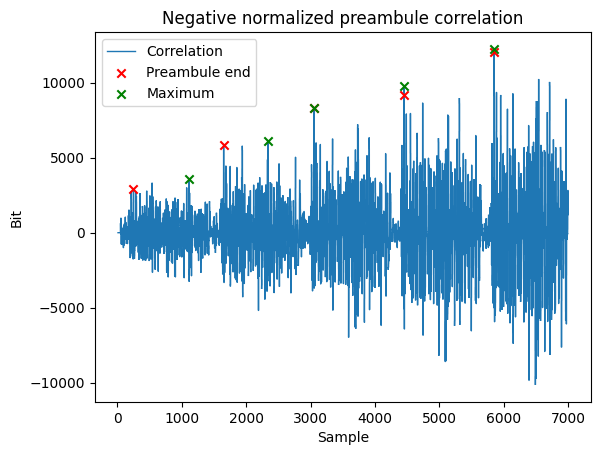

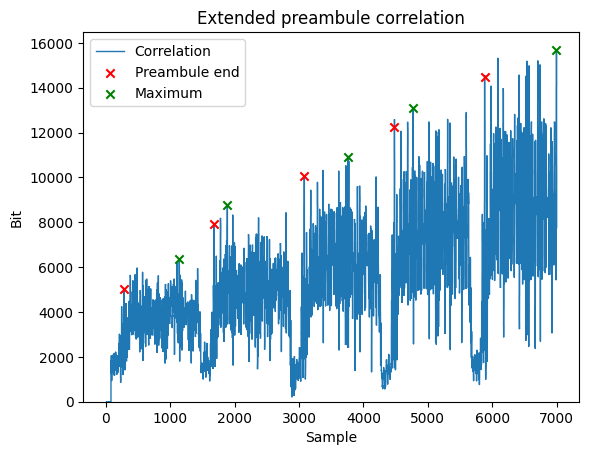

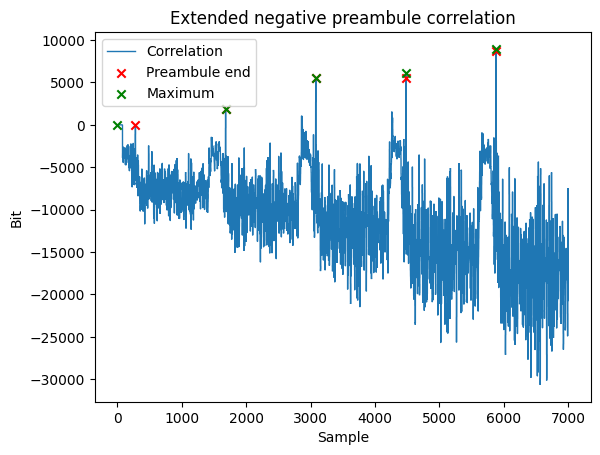

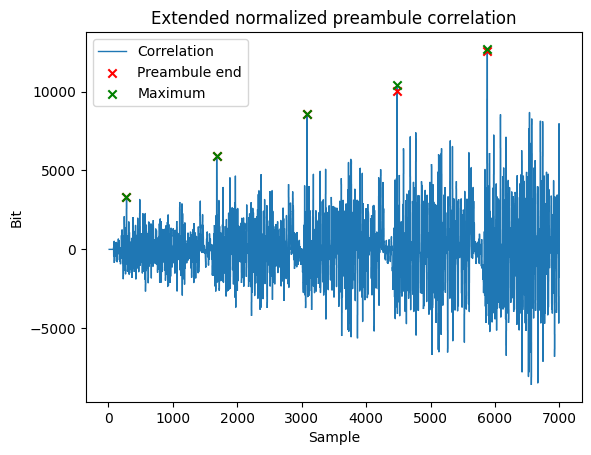

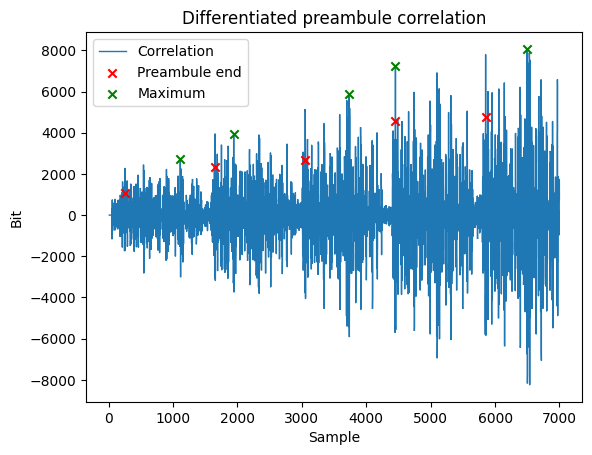

In [31]:
#Multiple signals
#Generate and plot simulated ADS-B
signal_amount = 5
multiple_signal_gaps = 200
multiple_amplitude_start = 0.3
multiple_amplitude_end = 1
multiple_amplitudes = np.linspace(multiple_amplitude_start, multiple_amplitude_end, signal_amount)
full_multiple_signal = np.zeros(0)
for i in range(signal_amount):
    full_multiple_signal = np.concatenate((full_multiple_signal, generate_ADSB(multiple_amplitudes[i], full_bits, multiple_signal_gaps)[2]))

one_signal_length = int(get_last_generated_signal_length()/t_prescaler)

plt.stairs(full_multiple_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Multiple ADS-B signal')
plt.show()

full_multiple_signal_digitized, digitized_t = digitize_signal(full_multiple_signal, 100E6, 10E6, 1.4, 2**10)
full_multiple_signal_digitized_energy = get_signal_energy(full_multiple_signal_digitized, len(preambule_list[Preambule.ExtendedNegative.value].get_coefficients()))

fig, ax1 = plt.subplots()
plot1 = ax1.stairs(full_multiple_signal_digitized, baseline=None, color="blue", label="Signal")
ax2 = ax1.twinx()
plo2 = ax2.plot(full_multiple_signal_digitized_energy, color="orange", label="Energy")
ax1.set_xlabel('Sample')
ax1.set_ylabel('Value')
plt.title('Filtered ADS-B signal')
plots = [plot1, plot2]
plots_labels = [plot.get_label() for plot in plots]
plt.legend(plots, plots_labels)
plt.show()

for preambule in preambule_list:
    curr_preambule_corr = preambule.get_correlation(full_multiple_signal_digitized)
    max_idxs = np.zeros(signal_amount)
    max_values = np.zeros(signal_amount)
    preambule_ends = np.zeros(signal_amount)
    preambule_ends_values = np.zeros(signal_amount)
    for i in range(signal_amount):
        max_idxs[i] = np.argmax(curr_preambule_corr[i*one_signal_length : i*one_signal_length + one_signal_length]) + i * one_signal_length
        max_values[i] = curr_preambule_corr[int(max_idxs[i])]
        preambule_ends[i] = multiple_signal_gaps + preambule.get_expected_maximum() + i * one_signal_length
        preambule_ends_values[i] = curr_preambule_corr[int(preambule_ends[i])]
    plt.stairs(curr_preambule_corr, label="Correlation", baseline=None)
    plt.xlabel('Sample')
    plt.ylabel('Bit')
    plt.title(preambule.get_name() + " preambule correlation")
    plt.scatter(preambule_ends, preambule_ends_values,
                marker='x', color='red', label="Preambule end")
    plt.scatter(max_idxs, max_values, marker='x', color='green', label="Maximum")
    plt.legend()
    plt.show()